In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('D:\\Career\\GradProj\\New deal\\Dataset\\parkinson_data.csv')
df.drop('Unnamed: 0', axis = 1,inplace=True)

df.columns = ['Time',
 'AccV',
 'AccML',
 'AccAP',
 'StartHesitation',
 'Turn',
 'Walking',
 'idx',
 'ID',
 'len_df']

In [3]:
df['class'] = np.array(df['Walking'] | df['StartHesitation'] | df['Turn'],dtype = int)
df[['normal','fog']] = pd.get_dummies(df['class'], prefix='class')


# Compute the mean and standard deviation of the dataset
data = np.asarray(df[['AccV','AccML','AccAP']] , dtype = np.float64)
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)

df[['AccV','AccML','AccAP']] = abs((data - mean) / std)

<AxesSubplot:>

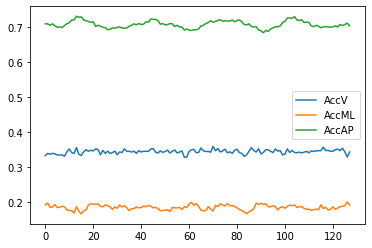

In [4]:
df[['AccV','AccML','AccAP']][0:128].plot()

In [5]:
x_win = []
y_win = []

x = df[['AccV','AccML','AccAP']]
y = df[['fog','normal']]

for i in range(0,len(df)-len(df)%256,128):
    x_win.append(x[i:i+256])
    y_win.append(y[i:i+256])
    
x_win.pop()
y_win.pop()
x_win = np.asarray(x_win,dtype = np.float32)
y_win = np.asarray(y_win,dtype = int)

In [6]:
from scipy import stats
y_win_s2l = []
for i in y_win:
    y_win_s2l.append(stats.mode(i)[0][0])
y_win_s2l = np.asarray(y_win_s2l,dtype = int)

In [7]:
x_win_aug = []
y_win_s2l_aug = []
for i in range(len(y_win_s2l)):
    x_win_aug.append(x_win[i])
    y_win_s2l_aug.append(y_win_s2l[i])
    
    if y_win_s2l[i,0]==1:
        x_win_aug.append(x_win[i])
        y_win_s2l_aug.append(y_win_s2l[i])
x_win_aug = np.asarray(x_win_aug,dtype = np.float32)
y_win_s2l_aug = np.asarray(y_win_s2l_aug,dtype = int)

In [8]:
# Importing Layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,BatchNormalization,Input,Bidirectional,Conv1D,MaxPooling1D,Flatten
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

In [9]:
# rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="accuracy",factor=0.5,patience=10,)
# earlystop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=20)
# checkpointer = ModelCheckpoint_tweaked(filepath='best.hdf5', verbose=0, save_best_only=True)
# csv_logger = tf.keras.callbacks.CSVLogger("model_history_log.csv", append=True)

In [10]:
# x_train, x_test, y_train, y_test = train_test_split(x_win_aug, y_win_s2l_aug, test_size=0.10)
# x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50)

# model_aug = Sequential([
#     LSTM(50, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,3), return_sequences = False ),
#     Dropout(0.2),
#     Dense(2, activation = 'softmax') 
# ])

# model_aug.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),#, clipvalue=0.5),
#                 loss='categorical_crossentropy', 
#                 metrics=['accuracy'],
                
#                 )

# model_aug.summary()
# tf.config.list_physical_devices('GPU')

In [11]:
# model_aug.fit(x_train, y_train, batch_size = 256, epochs = 1000, callbacks = [rlr,earlystop,checkpointer,csv_logger],validation_data=(x_val,y_val))

In [12]:
# model_aug.evaluate(x_test,y_test)

In [13]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        print(' - lr:',model.optimizer._decayed_lr(tf.float32).numpy())

In [16]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=False)
models = []
evals = []
k = 0
rlr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.001,decay_steps=205,decay_rate=0.96,staircase=True)

In [17]:
for train, test in kfold.split(x_win_aug, y_win_s2l_aug):
    x_train, x_val, y_train, y_val = train_test_split(x_win_aug[train], y_win_s2l_aug[train], test_size=0.10)

    model = Sequential([
        LSTM(50, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,3), return_sequences = False ),
        Dropout(0.2),

        Dense(2, activation = 'softmax') 
    ])
    
    model.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = rlr),#, clipvalue=0.5),
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'],
                    )

    
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=25)
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=f'best_{k}.hdf5', verbose=0, save_best_only=True,monitor='val_accuracy',mode='max')
    csv_logger = tf.keras.callbacks.CSVLogger(f"history_log_{k}.csv")

    model.fit(x_train, y_train, batch_size = 256, epochs = 500, callbacks = [earlystop,checkpointer,csv_logger,CustomCallback()],validation_data=(x_val,y_val))
    model = tf.keras.models.load_model(f'best_{k}.hdf5')
    models.append(model)
    evals.append(model.evaluate(x_win_aug[test],y_win_s2l_aug[test]))
    
    k+=1

Epoch 1/500
204/204 [==============================] - 8s 36ms/step - loss: 0.5902 - accuracy: 0.6697 - val_loss: 0.5419 - val_accuracy: 0.7124
Epoch 2/500
204/204 [==============================] - 7s 33ms/step - loss: 0.5545 - accuracy: 0.7302 - val_loss: 0.5216 - val_accuracy: 0.7570
Epoch 3/500
204/204 [==============================] - 7s 34ms/step - loss: 0.5970 - accuracy: 0.6676 - val_loss: 0.6470 - val_accuracy: 0.5799
Epoch 4/500
204/204 [==============================] - 7s 33ms/step - loss: 0.6334 - accuracy: 0.6255 - val_loss: 0.6821 - val_accuracy: 0.5201
Epoch 5/500
204/204 [==============================] - 6s 30ms/step - loss: 0.6694 - accuracy: 0.5839 - val_loss: 0.6450 - val_accuracy: 0.5989
Epoch 6/500
204/204 [==============================] - 5s 24ms/step - loss: 0.6461 - accuracy: 0.5958 - val_loss: 0.6416 - val_accuracy: 0.5970
Epoch 7/500
204/204 [==============================] - 7s 33ms/step - loss: 0.6369 - accuracy: 0.6175 - val_loss: 0.6119 - val_accuracy:

In [18]:
import tensorflow_addons as tfa
# x_win_aug[test],y_win_s2l_aug[test]
f1 = []
recalls = []
precisions = []
k = 0
kfold = KFold(n_splits=5, shuffle=False)
for train, test in kfold.split(x_win_aug, y_win_s2l_aug):
    metric = tfa.metrics.F1Score(num_classes=2,threshold=0.5)

    y_true = y_win_s2l_aug[test]
    y_pred = models[k].predict(x_win_aug[test])

    recall = tf.keras.metrics.Recall()
    recall.update_state(y_true, y_pred)
    recalls.append(recall.result().numpy())
    
    precision = tf.keras.metrics.Precision()
    precision.update_state(y_true, y_pred)
    precisions.append(precision.result().numpy())
    k+=1
f1 = 2 * (np.array(precisions) * np.array(recalls)) / (np.array(precisions) + np.array(recalls))

c:\ProgramData\Anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


452/452 [==============================] - 4s 8ms/step


In [19]:
import pickle
file1 = open('evaluations', 'wb')
file2 = open('models', 'wb')
file3 = open('scores', 'wb')
pickle.dump(evals, file1)
pickle.dump(models, file2)
pickle.dump([f1,recalls,precisions], file3)
file1.close()
file2.close()
file3.close()

INFO:tensorflow:Assets written to: ram://33aa6ddf-f218-4a90-b40e-dbdc37a5f264/assets


INFO:tensorflow:Assets written to: ram://33aa6ddf-f218-4a90-b40e-dbdc37a5f264/assets


INFO:tensorflow:Assets written to: ram://8801ea1e-c034-4aca-b1c4-5db0315e1d08/assets


INFO:tensorflow:Assets written to: ram://8801ea1e-c034-4aca-b1c4-5db0315e1d08/assets


INFO:tensorflow:Assets written to: ram://92854ad7-e70b-42b0-9506-588a9f0faa7d/assets


INFO:tensorflow:Assets written to: ram://92854ad7-e70b-42b0-9506-588a9f0faa7d/assets


INFO:tensorflow:Assets written to: ram://8f49292d-59b2-4a83-bc4e-f0770a25e163/assets


INFO:tensorflow:Assets written to: ram://8f49292d-59b2-4a83-bc4e-f0770a25e163/assets


INFO:tensorflow:Assets written to: ram://bfc54040-defc-4ccf-be0b-398746785a4d/assets


INFO:tensorflow:Assets written to: ram://bfc54040-defc-4ccf-be0b-398746785a4d/assets
